In [1]:
%cd ..

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from PIL import Image
import os
import models.DeiTModels  # Need to register the models!
from timm.models import create_model
from datasets.dataset_utils import img_equal_unsplit
import importlib
import time

# Settings and Parameters
Here we define the DeiT model that we wish to evaluate and the corresponding parameters to evaluate it.

In [3]:
model_name = 'deit_small_distilled_patch16_224'  # Must be something like 'deit_small_distilled_patch16_224'.
trained_model_path = 'mini_experiments/save_state_ep_210_new_best_MAE_7.448.pth'  # The path to trained model file (something like XYZ.pth)
label_factor = 10000  # The label factor used to train this specific model.
dataset = 'SHTB_DeiT'  # Must be the exact name of the dataset
save_results = True  # When true, save the images, GTs and predictions. A folder for this is created automatically.

# Prepare for evaluation
Use the settings to load the DeiT model and dataloader for the test set. Also loads the transform with which we can restore the original images. Cuda is required!
If save_results is True, also create the directory in which the predictions are saved.

In [4]:
model = create_model(
        model_name,
        init_path=None,
        num_classes=1000,  # Not yet used anyway. Must match pretrained model!
        drop_rate=0.,
        drop_path_rate=0.1,  # TODO: What does this do?
        drop_block_rate=None,
    )

model.cuda()

resume_state = torch.load(trained_model_path)
model.load_state_dict(resume_state['net'])

model.eval()

DistilledRegressionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attenti

In [5]:
dataloader = importlib.import_module(f'datasets.{dataset}.loading_data').loading_data
cfg_data = importlib.import_module(f'datasets.{dataset}.settings').cfg_data

_, _, test_loader, restore_transform = dataloader(model.crop_size)

320 train images found.
80 val images found.
316 test images found.


In [6]:
save_path = None
if save_results:
    save_folder = 'DeiT' + '_' + dataset + '_' + time.strftime("%m-%d_%H-%M", time.localtime())
    save_path = os.path.join('notebooks', save_folder)  # Manually change here is you want to save somewhere else
    os.mkdir(save_path)

# Evaluation loop and save funtion

In [7]:
def plot_and_save_results(save_path, img, img_idx, gt, prediction, pred_cnt, gt_cnt):
    img_save_path = os.path.join(save_path, f'IMG_{img_idx}_AE_{abs(pred_cnt - gt_cnt):.3f}.jpg')
    
    plt.figure()
    f, axarr = plt.subplots(1, 3, figsize=(13, 13))
    axarr[0].imshow(img)
    axarr[1].imshow(gt, cmap=cm.jet)
    axarr[1].title.set_text(f'GT count: {gt_cnt:.3f}')
    axarr[2].imshow(prediction, cmap=cm.jet)
    axarr[2].title.set_text(f'predicted count: {pred_cnt:.3f}')
    plt.tight_layout()
    plt.savefig(img_save_path)
    plt.close()

In [10]:
def eval_model(model, test_loader, show_predictions, restore_transform, label_factor, cfg_data):
    with torch.no_grad():
        AEs = []  # Absolute Errors
        SEs = []  # Squared Errors

        for idx, (img, img_patches, gt_patches) in enumerate(test_loader):
            img_patches = img_patches.squeeze().cuda()
            gt_patches = gt_patches.squeeze().unsqueeze(1)  # Remove batch dim, insert channel dim
            img = img.squeeze()  # Remove batch dimension
            _, img_h, img_w = img.shape  # Obtain image dimensions. Used to reconstruct GT and Prediction
            
            img = restore_transform(img)

            pred_den = model(img_patches)  # Precicted density crops
            pred_den = pred_den.cpu()

            # Restore GT and Prediction
            gt = img_equal_unsplit(gt_patches, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
            den = img_equal_unsplit(pred_den, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
            gt = gt.squeeze()  # Remove channel dim
            den = den.squeeze()  # Remove channel dim

            
            pred_cnt = den.sum() / label_factor
            gt_cnt = gt.sum() / cfg_data.LABEL_FACTOR
            
            AEs.append(torch.abs(pred_cnt - gt_cnt).item())
            SEs.append(torch.square(pred_cnt - gt_cnt).item())
            relative_error = AEs[-1] / gt_cnt * 100
            print(f'IMG {idx:<3} '
                  f'Prediction: {pred_cnt:<9.3f} '
                  f'GT: {gt_cnt:<9.3f} '
                  f'Absolute Error: {AEs[-1]:<9.3f} '
                  f'Relative Error: {relative_error:.1f}%')
            
            if save_path:
                plot_and_save_results(save_path, img, idx, gt, den, pred_cnt, gt_cnt)
            
        MAE = np.mean(AEs)
        MSE = np.sqrt(np.mean(SEs))

    return MAE, MSE

IMG 0   Prediction: 25.170    GT: 22.743    Absolute Error: 2.428     Relative Error: 10.7%
IMG 1   Prediction: 157.931   GT: 175.638   Absolute Error: 17.706    Relative Error: 10.1%
IMG 2   Prediction: 125.140   GT: 156.493   Absolute Error: 31.353    Relative Error: 20.0%
IMG 3   Prediction: 37.305    GT: 36.219    Absolute Error: 1.086     Relative Error: 3.0%
IMG 4   Prediction: 67.581    GT: 68.812    Absolute Error: 1.231     Relative Error: 1.8%
IMG 5   Prediction: 58.681    GT: 56.467    Absolute Error: 2.215     Relative Error: 3.9%
IMG 6   Prediction: 43.546    GT: 43.457    Absolute Error: 0.089     Relative Error: 0.2%
IMG 7   Prediction: 217.926   GT: 220.488   Absolute Error: 2.563     Relative Error: 1.2%
IMG 8   Prediction: 172.374   GT: 163.917   Absolute Error: 8.457     Relative Error: 5.2%


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

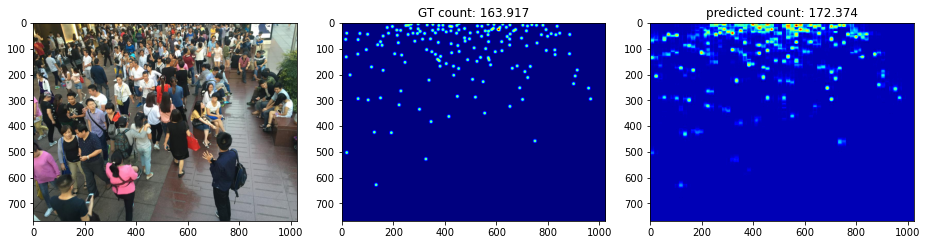

In [11]:
MAE, MSE = eval_model(model, test_loader, save_path, restore_transform, label_factor, cfg_data)
print(f'MAE: {MAE:<9.3f} Root MSE: {MSE}')